<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', 500)
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.MSZoning.unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [4]:
# Drop all non-residential properties

house = house[house['MSZoning'] != 'C (all)'].drop(columns='Id')

In [5]:
house.shape

(1450, 80)

In [6]:
house.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [7]:
# Set year as zero for houses without garage
house[['LotFrontage','GarageYrBlt','MasVnrArea']] = house[['LotFrontage','GarageYrBlt','MasVnrArea']].fillna(0)

In [8]:
# Changing cell value from NaN to 'No' to correctly reflect its category
house.loc[948,'BsmtExposure'] = 'No'

In [9]:
# Changing cell value from NaN to 'Unf' to correctly reflect its category
house.loc[332,'BsmtFinType2'] = 'Unf'

In [10]:
# Dropping Total Basement Square Feet as it is accounted for by BsmtFinSF1, BsmtFinSF2, BsmtUnfSF
house.drop(columns=['TotalBsmtSF'], inplace=True)

In [11]:
# Binarizing feature Alley
house['Alley'] = np.where(house['Alley'].isnull(), 0, 1)

In [12]:
# Given a house price, setting missing electrical value to highest quality for conservative guess
house.loc[1379,'Electrical'] = 'SBrkr'

In [13]:
# Filling remaining null values as NA
house.fillna('NA', inplace=True)

In [14]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 79 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null int32
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non

In [15]:
# importing csv as dataframe to select features
feature_selector = pd.read_csv('./book1.csv', index_col='Features')

In [16]:
feature_selector.head()

,Choice
Features,
MSSubClass,1
MSZoning,1
LotFrontage,1
LotArea,1
Street,1


In [17]:
# Filtering for columns deemed as fixed features
fixed_features = house[feature_selector[feature_selector['Choice'] == 1].index.values]

In [18]:
# Creating dummies for categorical values
fixed_features = pd.get_dummies(fixed_features,columns=['MSSubClass','MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities','LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'MasVnrType', 'Foundation','GarageType', 'MiscFeature'])

In [19]:
target = house[['SalePrice','YrSold']]
fixed_features['YrSold'] = house['YrSold']

In [20]:
# Splitting dataset into train and test sets
target_2010 = target[target['YrSold'] == 2010].drop(columns=['YrSold'])
target_pre2010 = target[target['YrSold'] != 2010].drop(columns=['YrSold'])
fixed_features_2010 = fixed_features[fixed_features['YrSold'] == 2010].drop(columns=['YrSold'])
fixed_features_pre2010 = fixed_features[fixed_features['YrSold'] != 2010].drop(columns=['YrSold'])

In [21]:
# Standardising features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
fixed_features_pre2010 = pd.DataFrame(ss.fit_transform(fixed_features_pre2010), columns=fixed_features_pre2010.columns)

In [22]:
fixed_features_pre2010.head()

,LotFrontage,LotArea,Alley,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_NA,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,0.218265,-0.202915,-0.265239,1.038568,0.875532,0.490654,0.571958,-0.285098,-0.945094,-0.796427,1.148046,-0.122443,0.356109,1.129289,-0.251787,0.776644,1.218379,0.162086,-0.205061,0.910241,-0.970020,0.291570,0.292575,0.333297,-0.756584,0.197698,-0.348237,-0.118498,-0.269975,-0.073445,-0.07563,-0.753723,-0.221948,-0.048507,-0.097358,-0.332173,1.945897,-0.210042,-0.112598,-0.203874,-0.112598,-0.19104,-0.251452,-0.212065,-0.084215,-0.138343,-0.216063,-0.112598,0.515118,-0.424329,-0.048507,0.048507,-0.715839,-0.167803,-0.088806,0.772981,-0.216063,-0.195398,-0.157669,0.343672,0.027984,-0.027984,-0.459755,-0.260133,-0.182057,-0.056033,0.612922,0.237062,-0.216063,-0.093177,-0.112598,-0.03959,-0.108979,-0.214071,-0.138343,2.885908,-0.197546,-0.273592,-0.246132,-0.141252,-0.105242,-0.19104,-0.420471,-0.074212,-0.233357,-0.165321,-0.238897,-0.288185,-0.132348,-0.218039,-0.19323,-0.254951,-0.126088,-0.162807,-0.093177,-0.184338,-0.240722,0.394354,-0.062672,-0.116109,-0.079368,-0.141252,-0.027984,-0.056033,-0.03959,-0.056033,0.101374,-0.027984,-0.03959,-0.027984,-0.027984,-0.03959,0.439633,-0.141252,-0.19104,-0.175058,-0.289775,-0.345093,-0.105242,-0.982931,-0.079368,-0.088806,1.500636,-0.157669,-0.218039,-0.105242,1.503398,-0.074212,-1.197617,-0.309927,-0.342247,-0.856771,1.103970,-0.129253,-0.056033,-0.03959,-0.06868,0.824239,-0.105242,-0.254951,-0.074212,-0.606884,-0.237062,-0.03959,0.177418,-0.027984,-0.167803,-0.027984
1,0.650287,-0.092329,-0.265239,0.146572,-0.436226,-0.569494,1.163930,-0.285098,-0.645103,0.252007,-0.803350,-0.122443,-0.492294,-0.802748,3.770504,0.776644,-0.765173,0.162086,-0.205061,-0.322709,0.593266,0.230862,0.292575,-0.074931,1.653565,-0.714047,-0.348237

In [23]:
# Near Zero Variance Function (Identify X with near 0 var)
def nearZeroVariance(X, freqCut = 95 / 5, uniqueCut = 10):
    '''
    Determine predictors with near zero or zero variance.
    Inputs:
    X: pandas data frame
    freqCut: the cutoff for the ratio of the most common value to the second most common value
    uniqueCut: the cutoff for the percentage of distinct values out of the number of total samples
    Returns a tuple containing a list of column names: (zeroVar, nzVar)
    '''

    colNames = X.columns.values.tolist()
    freqRatio = dict()
    uniquePct = dict()

    for names in colNames:
        counts = (
            (X[names])
            .value_counts()
            .sort_values(ascending = False)
            .values
            )

        if len(counts) == 1:
            freqRatio[names] = -1
            uniquePct[names] = (len(counts) / len(X[names])) * 100
            continue

        freqRatio[names] = counts[0] / counts[1]
        uniquePct[names] = (len(counts) / len(X[names])) * 100

    zeroVar = list()
    nzVar = list()
    for k in uniquePct.keys():
        if freqRatio[k] == -1:
            zeroVar.append(k)

        if uniquePct[k] < uniqueCut and freqRatio[k] > freqCut:
            nzVar.append(k)

    return(zeroVar, nzVar)

In [24]:
# Dropping columns with near zero variance
fixed_features_pre2010 = fixed_features_pre2010.drop(columns=nearZeroVariance(fixed_features_pre2010)[1])

In [25]:
fixed_features_pre2010.shape

(1278, 57)

### RFE Feature Selection

In [26]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10, n_jobs=-1)
selector = selector.fit(fixed_features_pre2010, target_pre2010.values.ravel())

print selector.support_
print selector.ranking_   

[False  True False  True  True False False  True  True  True  True  True
  True False  True  True  True False  True  True False False False False
 False False False False  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[ 9  1  4  1  1  7  8  1  1  1  1  1  1  2  1  1  1  6  1  1 10 12 13 15
  5 16  3 11  1  1  1 14  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1]


In [27]:
# Extracting names of selected features
rfecv_columns = np.array(fixed_features_pre2010.columns)[selector.support_]
rfecv_columns

array(['LotArea', 'YearBuilt', 'YearRemodAdd', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'WoodDeckSF', 'MSSubClass_20', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_Inside', 'Neighborhood_CollgCr',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Somerst', 'Condition1_Feedr', 'Condition1_Norm',
       'BldgType_1Fam', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_1Story', 'HouseStyle_2Story', 'MasVnrType_BrkFace',
       'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_BrkTil',
       'Foundation_CBlock', 'Foundation_PConc', 'GarageType_Attchd',
       'GarageType_BuiltIn', 'GarageType_Detchd', 'GarageType_NA'],
      dtype=object)

In [28]:
# Filtering training set to only include selected RFE model features
rfe_fixed_features = fixed_features_pre2010[rfecv_columns]

### Select K Best Feature Selection

In [29]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [30]:
# Build the selector for F-regression and Mutual info regression
# Documention states above models are for regression task and continuous targets

skb_f = SelectKBest(f_regression, k=15)
skb_mutual = SelectKBest(mutual_info_regression, k=15)

# Train the selector on the data.
skb_f.fit(fixed_features_pre2010, target_pre2010.values.ravel())
skb_mutual.fit(fixed_features_pre2010, target_pre2010.values.ravel())

# Examine the results.
kbest_f = pd.DataFrame([fixed_features_pre2010.columns,list(skb_f.scores_)], index=['feature','f_regression']).T.sort_values('f_regression', ascending=False)
kbest_mutual = pd.DataFrame([fixed_features_pre2010.columns,list(skb_mutual.scores_)], index=['feature','mutual_info']).T.sort_values('mutual_info', ascending=False)

C:\Users\Luther\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [31]:
kbest_f.head()

,feature,f_regression
7,GrLivArea,1284
16,GarageCars,894.937
17,GarageArea,844.791
6,1stFlrSF,711.931
10,FullBath,590.937


In [32]:
kbest_mutual.head()

,feature,mutual_info
7,GrLivArea,0.476907
3,YearBuilt,0.364383
16,GarageCars,0.364296
17,GarageArea,0.351104
6,1stFlrSF,0.305011


### Lasso Regression

In [33]:
# select the best alpha with LassoCV
from sklearn.linear_model import LassoCV, Lasso

optimal_lasso = LassoCV(n_alphas=500, random_state=1, n_jobs=-1, cv=10, verbose=1)
optimal_lasso.fit(fixed_features_pre2010, target_pre2010.values.ravel())
optimal_lasso.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

631.3155971221823

### Choosing Best Model

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Defining a cross valuation function to test different models.
def score(X, y):
    scores = cross_val_score(lr, X, y, cv=10, n_jobs=-1)
    return scores.mean()

# Perform 10-fold cross validation for RFE
rfe_scores = score(rfe_fixed_features, target_pre2010.values.ravel())

# Perform 10-fold cross validation for K best F-regression
f_scores = score(fixed_features_pre2010[kbest_f.feature.values[0:15]], target_pre2010.values.ravel())

# Perform 10-fold cross validation for K best mutual info
mutual_scores = score(fixed_features_pre2010[kbest_mutual.feature.values[0:15]], target_pre2010.values.ravel())

# Perform 10-fold cross validation for lasso
lassoreg = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = np.mean(cross_val_score(lassoreg, fixed_features_pre2010, target_pre2010.values.ravel(), cv=10, n_jobs=-1))

# Perform 10-fold cross validation for Linear Regression with no feature selection
lr_scores = score(fixed_features[fixed_features['YrSold'] != 2010].drop(columns=['YrSold']), target_pre2010.values.ravel())

In [35]:
print 'RFE_Score: {}'.format(rfe_scores) 
print 'F-reg_Score: {}'.format(f_scores) 
print 'Mutual_info_Score: {}'.format(mutual_scores) 
print 'Lasso_Score: {}'.format(lasso_scores) 
print 'Linear_Score: {}'.format(lr_scores) 

RFE_Score: 0.783442080527
F-reg_Score: 0.739287427906
Mutual_info_Score: 0.723150449947
Lasso_Score: 0.776852520493
Linear_Score: 0.764898107476


### Linear Regression with RFE model (Best Score)

In [36]:
# Filtering test features for RFE model columns + standardising variables
rfe_test_features = fixed_features_2010[rfecv_columns]
rfe_test_features = pd.DataFrame(ss.fit_transform(rfe_test_features), columns=rfe_test_features.columns)

# Performing linear regression on test features to predict price
model = lr.fit(rfe_fixed_features, target_pre2010.values.ravel())
predictions = model.predict(rfe_test_features)

In [37]:
# Calculating r2 for chosen RFE model
r2 = metrics.r2_score(target_2010.values.ravel(), predictions)

print 'R2_Score: {}'.format(r2)

R2_Score: 0.822640621706


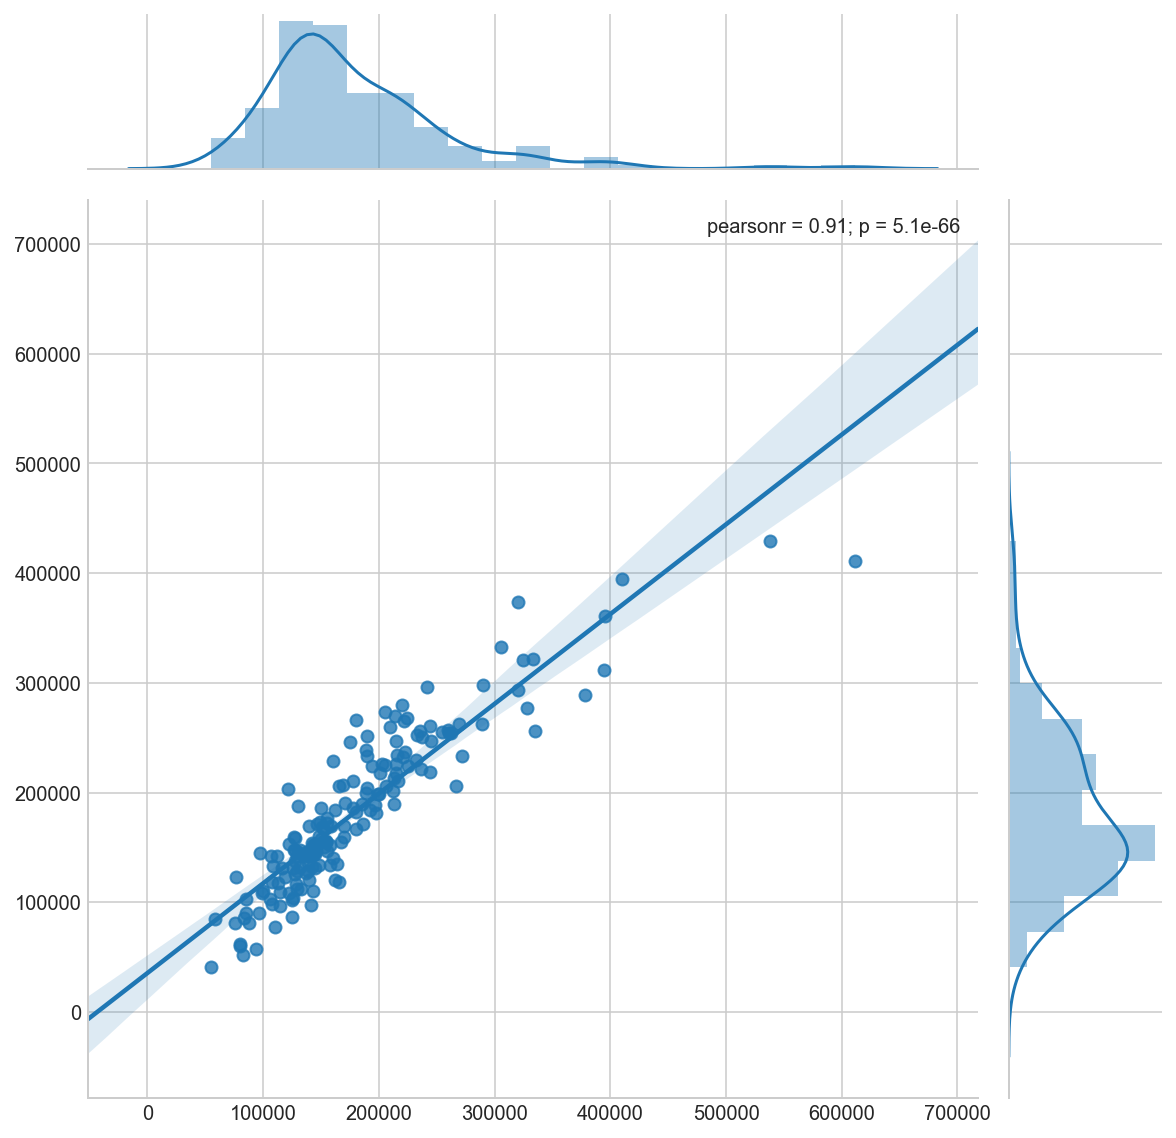

In [38]:
sns.jointplot(target_2010.values.ravel(), predictions, kind='reg', size=8)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [39]:
# A:
train_predictions = model.predict(rfe_fixed_features)

In [40]:
# Removing fixed features from full dataset
renovate_features = house[feature_selector[feature_selector['Choice'] == 0].index.values]

In [41]:
# Further dropping non-renovatable features
renovate_features = renovate_features.drop(columns=['MoSold', 'SaleType', 'SaleCondition', 'SalePrice',])

In [42]:
renovate_features.head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YrSold
0,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,RFn,TA,TA,Y,NA,NA,2008
1,6,8,Gable,CompShg,MetalSd,MetalSd,TA,TA,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NA,NA,2007
2,7,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NA,NA,2008
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NA,NA,2006
4,8,5,Gable,CompShg,VinylSd,VinylSd,Gd,TA,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NA,NA,2008


In [43]:
# Computing residual values for pre-2010
effect_pre2010 = target_pre2010['SalePrice'] - train_predictions 

In [44]:
effect_pre2010.shape

(1278L,)

In [45]:
# Creating dummies for renovatable features
renovate_features = pd.get_dummies(renovate_features, columns=[u'OverallQual', u'OverallCond', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'ExterQual', u'ExterCond', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageFinish', u'GarageQual',
       u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence'])

In [46]:
renovate_features.head()

,YrSold,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_NA,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NA,FireplaceQu_Po,FireplaceQu_TA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA
0,2008,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
1,2007,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,2008,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
3,2006,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
4,2008,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [47]:
renovate_features.shape

(1450, 166)

In [48]:
# Splitting to train and test dataset
renovate_features_2010 = renovate_features[renovate_features['YrSold'] == 2010].drop(columns=['YrSold'])
renovate_features_pre2010 = renovate_features[renovate_features['YrSold'] != 2010].drop(columns=['YrSold'])

In [49]:
# Dropping columns with zero and near zero variance
renovate_features_pre2010 = renovate_features_pre2010.drop(columns=nearZeroVariance(renovate_features_pre2010)[1]).drop(columns=nearZeroVariance(renovate_features_pre2010)[0])

### RFE Feature Selection

In [50]:
# Recursive Feature Elimination

selector2 = RFECV(lr, step=1, cv=10, n_jobs=-1)
selector2 = selector2.fit(renovate_features_pre2010, effect_pre2010.ravel())

print selector2.support_
print selector2.ranking_   

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [51]:
# Identifying names of selected columns
rfecv_columns2 = np.array(renovate_features_pre2010.columns)[selector2.support_]
rfecv_columns2

array(['OverallQual_4', 'OverallQual_5', 'OverallQual_6', 'OverallQual_7',
       'OverallQual_8', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'RoofStyle_Gable', 'RoofStyle_Hip',
       'Exterior1st_HdBoard', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_VinylSd',
       'Exterior1st_Wd Sdng', 'Exterior2nd_HdBoard',
       'Exterior2nd_MetalSd', 'Exterior2nd_Plywood',
       'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'ExterQual_Gd',
       'ExterQual_TA', 'ExterCond_Gd', 'ExterCond_TA', 'BsmtQual_Ex',
       'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Gd', 'BsmtCond_TA',
       'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn',
       'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ',
       'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec',
       'BsmtFinType1_Unf', 'BsmtFinType2_Unf', 'HeatingQC_Ex',
       'HeatingQC_Gd', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y',
       'Electrical_FuseA', 'Electrical_SB

In [52]:
# Filtering training set to only include selected RFE model features
rfe_renovate_features = renovate_features_pre2010[rfecv_columns2]

### Select K Best Feature Selection

In [53]:
# Build the selector — we'll build one with each score type.
skb_f2 = SelectKBest(f_regression, k=15)
skb_mutual2 = SelectKBest(mutual_info_regression, k=15)

# Train the selector on the data.
skb_f2.fit(renovate_features_pre2010, effect_pre2010.ravel())
skb_mutual2.fit(renovate_features_pre2010, effect_pre2010.ravel())

# Examine the results.
kbest_f2 = pd.DataFrame([renovate_features_pre2010.columns,list(skb_f2.scores_)], index=['feature','f_regression']).T.sort_values('f_regression', ascending=False)
kbest_mutual2 = pd.DataFrame([renovate_features_pre2010.columns,list(skb_mutual2.scores_)], index=['feature','mutual_info']).T.sort_values('mutual_info', ascending=False)

C:\Users\Luther\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [54]:
kbest_f2.head()

,feature,f_regression
48,KitchenQual_Ex,72.5344
25,BsmtQual_Ex,60.5285
51,Functional_Typ,45.8007
31,BsmtExposure_Gd,31.674
33,BsmtExposure_No,20.4554


In [55]:
kbest_mutual2.head()

,feature,mutual_info
25,BsmtQual_Ex,0.0500197
48,KitchenQual_Ex,0.0477266
50,KitchenQual_TA,0.0475875
52,FireplaceQu_Gd,0.047272
51,Functional_Typ,0.0370442


### Lasso Regression

In [56]:
# select the best alpha with LassoCV
optimal_lasso2 = LassoCV(n_alphas=500, random_state=1, n_jobs=-1, cv=10, verbose=1)
optimal_lasso2.fit(renovate_features_pre2010, effect_pre2010.ravel())
optimal_lasso2.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

161.08475233298984

### Choosing Best Model

In [57]:
# Perform 10-fold cross validation for RFE
rfe_scores2 = score(rfe_renovate_features, effect_pre2010.ravel())

# Perform 10-fold cross validation for K best F-regression
f_scores2 = score(renovate_features_pre2010[kbest_f2.feature.values[0:15]], effect_pre2010.ravel())

# Perform 10-fold cross validation for K best mutual info
mutual_scores2 = score(renovate_features_pre2010[kbest_mutual2.feature.values[0:15]], effect_pre2010.ravel())

# Perform 10-fold cross validation for lasso
lassoreg2 = Lasso(alpha=optimal_lasso2.alpha_)
lasso_scores2 = np.mean(cross_val_score(lassoreg2, renovate_features_pre2010, effect_pre2010.ravel(), cv=10, n_jobs=-1))

# Perform 10-fold cross validation for Linear Regression with no feature selection
lr_scores2 = score(renovate_features_pre2010, effect_pre2010.ravel())

In [58]:
print 'RFE_Score: {}'.format(rfe_scores2) 
print 'F-reg_Score: {}'.format(f_scores2) 
print 'Mutual_info_Score: {}'.format(mutual_scores2) 
print 'Lasso_Score: {}'.format(lasso_scores2) 
print 'Linear_Score: {}'.format(lr_scores2) 

RFE_Score: 0.121716658902
F-reg_Score: 0.125166200466
Mutual_info_Score: 0.130003029919
Lasso_Score: 0.138905938634
Linear_Score: 0.121716658902


### Performing Lasso Regression (Best Score)

In [59]:
model2 = lassoreg2.fit(renovate_features_pre2010, effect_pre2010.ravel())

prediction2 = model2.predict(renovate_features_2010[renovate_features_pre2010.columns])

In [60]:
effect_2010 = target_2010['SalePrice'] - predictions

In [61]:
# Calculating r2 for chosen lasso model
reno_r2 = metrics.r2_score(effect_2010, prediction2)

print 'R2_Score: {}'.format(reno_r2)

R2_Score: 0.256638367106


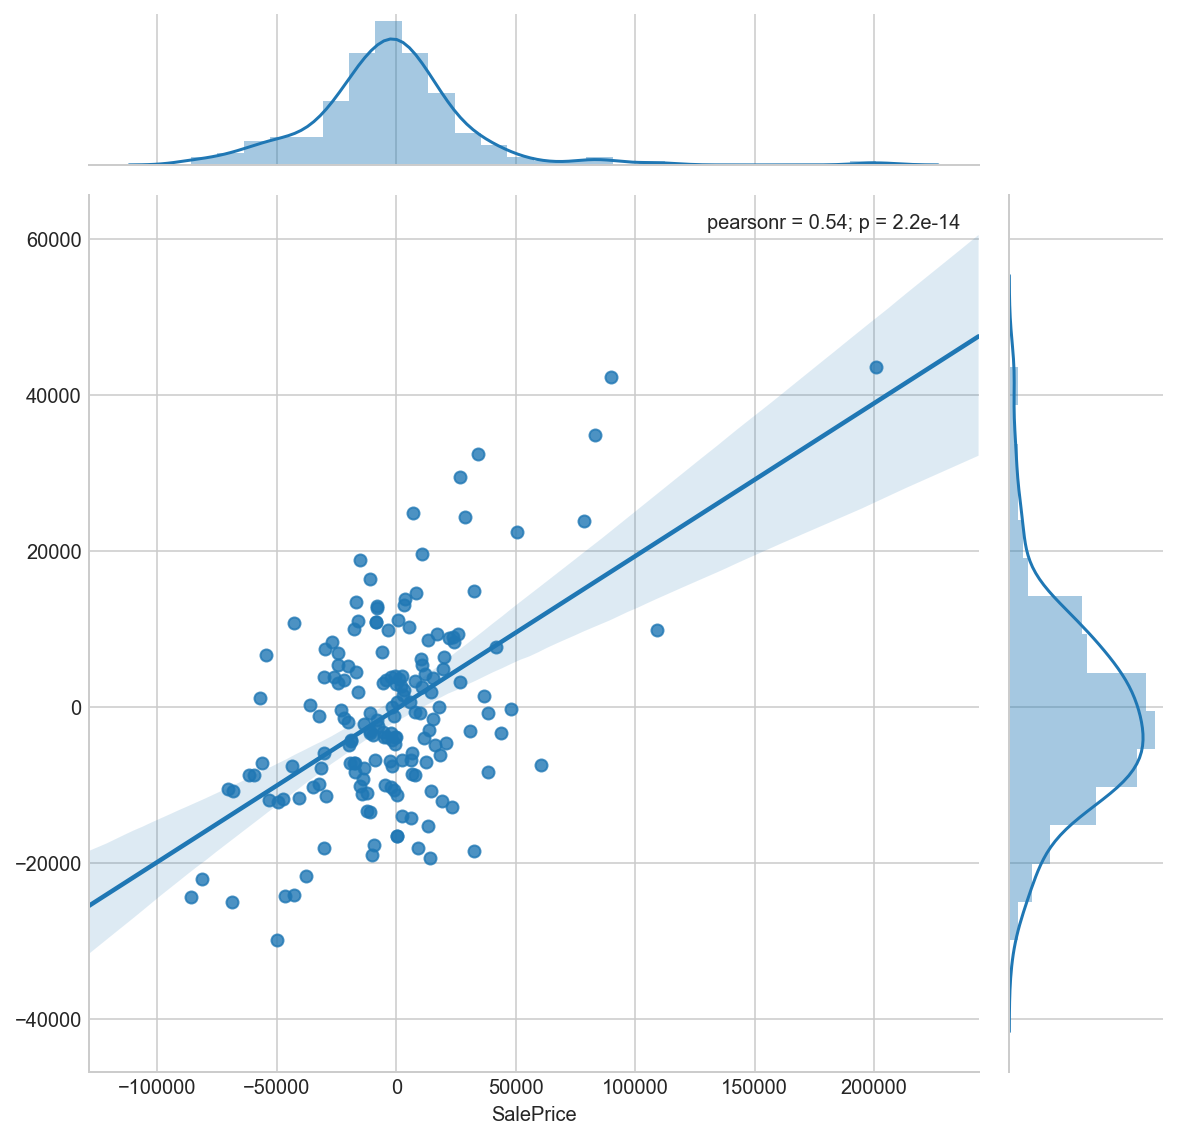

In [62]:
sns.jointplot(effect_2010, prediction2, kind='reg', size=8)

### Conclusion

The r2 from the model is only at 0.25. This means renovatable features only explains about 25% of the residuals from the fixed features model.

This signals that other factors not captured in the model could be at play. For e.g., the features only focuses on micro aspects of the house. 

An improvement to the model could be to include macro features like GDP growth, interest rates, exchange rates etc as these are features which will drive sentiments and demand as well.

Another factor will stem from the fact that we determined pre-2010 residuals using the same training features we used to train the model. In this case, the pre-2010 residuals may not be a fair estimate. We may instead perform a further train-test-split on the test data to run the model instead.





<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

<Container object of 6 artists>

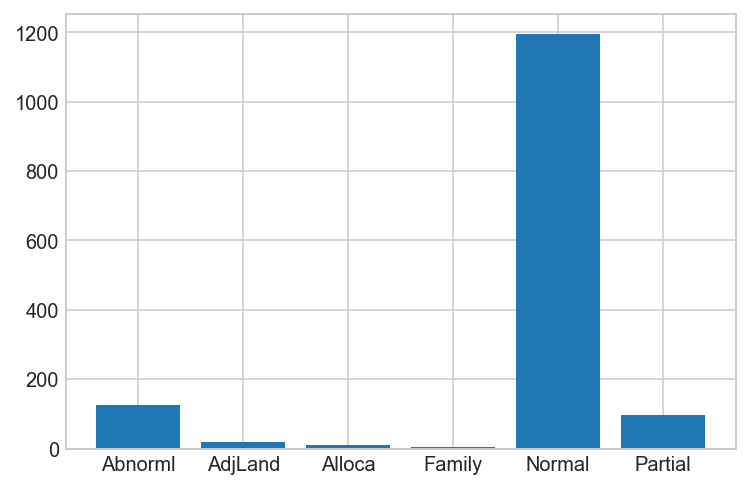

In [63]:
# Checking distribution of Sale Condition
plt.bar(house['SaleCondition'].unique(), house['SaleCondition'].value_counts())

In [64]:
house.SaleCondition.value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [65]:
# Binarising Sale Condition - 1 if abnormal else 0 for other categories
house['SaleCondition'] = house.SaleCondition.map(lambda x: 1 if x == 'Abnorml' else 0)

In [66]:
# Check if above works
house['SaleCondition'].value_counts()

0    1354
1      96
Name: SaleCondition, dtype: int64

In [67]:
# Dropping irrelavant columns as this are post sale metrics
house = house.drop(columns=['YrSold', 'SaleType','SalePrice'])

In [68]:
y = house['SaleCondition'].values
X = house.drop(columns=['SaleCondition'])

In [69]:
X.describe(include='O').columns.values

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype=object)

In [70]:
# Getting dummies for categorical columns
X = pd.get_dummies(X, columns=['MSSubClass','MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'OverallQual', 'OverallCond','Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature'])

In [71]:
X.shape

(1450, 314)

In [72]:
# Standardising features
X = pd.DataFrame(ss.fit_transform(X), columns=X.columns)

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Balanced weight Logistic Regression

In [74]:
# Performing grid search to find paramenters for balanced weight Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression()

gs_params = {'penalty':['l1','l2'],
             'solver':['liblinear'],
             'class_weight':['balanced'],
             'C':np.logspace(-5,0,100)}

lr_gridsearch = GridSearchCV(logreg, gs_params, cv=10, verbose=1, n_jobs=-1, scoring='roc_auc')

In [75]:
# Training model
lr_gridsearch.fit(X_train, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 791 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1491 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.12332e-05, ..., 8.90215e-01, 1.00000e+00]), 'class_weight': ['balanced'], 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [76]:
print lr_gridsearch.best_score_
print lr_gridsearch.best_params_

0.667648776047028
{'penalty': 'l1', 'C': 0.013530477745798061, 'solver': 'liblinear', 'class_weight': 'balanced'}


In [77]:
# Selecting the model with best hyper parameters
model3 = lr_gridsearch.best_estimator_

In [78]:
# Predicting y values based on best model
yhat = model3.predict(X_test)

In [79]:
from sklearn.metrics import classification_report

In [80]:
print classification_report(y_test, yhat)

             precision    recall  f1-score   support

          0       0.95      0.55      0.69       271
          1       0.09      0.63      0.16        19

avg / total       0.90      0.55      0.66       290



Model seem to be performing ok (High precision on 0 and ok recall on 1)

### SMOTE (over-sampling model)

In [81]:
from imblearn.over_sampling import SMOTE

In [82]:
os = SMOTE(random_state=42, ratio='minority')
X_os, y_os = os.fit_sample(X_train, y_train)

In [83]:
gs_params2 = {'penalty':['l1','l2'],
             'solver':['liblinear'],
             'C':np.logspace(-5,0,100)}

smote = GridSearchCV(logreg, gs_params2, cv=10, verbose=1, n_jobs=-1, scoring='roc_auc')

In [84]:
smote.fit(X_os, y_os)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.0min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.12332e-05, ..., 8.90215e-01, 1.00000e+00]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [85]:
y_os_pred = smote.predict(X_test)

In [86]:
print classification_report(y_test, y_os_pred)

             precision    recall  f1-score   support

          0       0.93      0.82      0.87       271
          1       0.06      0.16      0.08        19

avg / total       0.88      0.78      0.82       290



Model does not seem to be performing well.

Although Precision on '0' is high, recall on '1' is low.

### Tomek Links (under-sampling model)

In [87]:
from imblearn.under_sampling import TomekLinks

In [88]:
us = TomekLinks(random_state=42)
X_us, y_us = us.fit_sample(X_train, y_train)

In [89]:
y_us.sum()

77

In [90]:
y_us.shape

(1137L,)

In [91]:
gs_params3 = {'penalty':['l1','l2'],
             'solver':['liblinear'],
             'C':np.logspace(-5,0,100)}

tomek = GridSearchCV(logreg, gs_params3, cv=10, verbose=1, n_jobs=-1, scoring='roc_auc')

In [92]:
tomek.fit(X_us, y_us)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 303 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1503 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   48.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.12332e-05, ..., 8.90215e-01, 1.00000e+00]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [93]:
y_us_pred = tomek.predict(X_test)

In [94]:
print classification_report(y_test, y_us_pred)

             precision    recall  f1-score   support

          0       0.93      1.00      0.97       271
          1       0.00      0.00      0.00        19

avg / total       0.87      0.93      0.90       290



C:\Users\Luther\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model does not seem to be performing well.

Although Precision on '0' is high, recall on '1' is zero. Seems that the model does not undersample properly.

### Identifying features from selected model to predict 'Abnormal'

In [95]:
coef_df = pd.DataFrame({
        'coef': model3.coef_[0],
        'feature':X.columns})

coef_df['abs_coef'] = np.abs(coef_df.coef)

# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)

# Show non-zero coefs and predictors
coef_df[coef_df.coef != 0]

,coef,feature,abs_coef
4,-0.184328,YearRemodAdd,0.184328
270,-0.156235,FireplaceQu_Gd,0.156235
169,0.067981,Exterior1st_Stone,0.067981
300,0.054750,PoolQC_Ex,0.054750
190,0.033503,MasVnrType_BrkCmn,0.033503
255,0.016827,Electrical_Mix,0.016827
63,0.016269,LotConfig_Corner,0.016269
266,0.016077,Functional_Sev,0.016077
124,0.005067,Condition2_Artery,0.005067
161,0.002843,Exterior1st_BrkComm,0.002843
